<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="300" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** <span style="color:purple"> <font size="4.5"> **Ana María Aguilera Gómez, <span style="color:blue"> Esteban Márquez Delgado**

**Fecha:** 27 de noviembre del 2021.
   
**Expedientes:** 
- Ana María Aguilera Gómez: 720567 
- Esteban Márquez Delgado: 700637 
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github:**   https://github.com/EMarquez7/Tarea10_AMAguilera_EMarquez

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

> Se calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

#### Código de solución `ESTUDIANTE 1: Ana María Aguilera`

In [10]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import yfinance as yf
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [11]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [12]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_m = closes.loc[:,'MSFT']
closes_m

Date
2017-01-03     58.186
2017-01-04     57.925
2017-01-05     57.925
2017-01-06     58.427
2017-01-09     58.241
               ...   
2021-11-19    343.110
2021-11-22    339.830
2021-11-23    337.680
2021-11-24    337.910
2021-11-26    329.680
Name: MSFT, Length: 1235, dtype: float64

In [13]:
# calcular rendimientos
ret_m = calc_daily_ret(closes_m)

In [14]:
# descargar opciones

def options_yf(ticker : "Ticker en formato string"):
    """
    options_yf descarga información de opciones financieras con ayuda de yfinance
    
    *ticker : es el símbolo de cotización de la acción
    """
    stock = yf.Ticker(ticker)
    calls, puts = stock.option_chain(stock.options[0]) 
    return calls, puts

c, p = options_yf("MSFT")

## 1. CALL (DOWN & OUT)

### Simulación con la suposición de rendimientos normales:

In [15]:
# opción que deseamos valuar

K = 330 # strike price
opt_deseada = c.loc[(c.strike==K)]
opt_deseada

,contractSymbol,lastTradeDate,strike,...,inTheMoney,contractSize,currency
25,MSFT211203C00330000,2021-11-26 17:59:48,330.0,...,False,REGULAR,USD


In [22]:
#Información de la opción
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

contractSymbol       MSFT211203C00330000
lastTradeDate        2021-11-26 17:59:48
strike                             330.0
lastPrice                            5.1
bid                                  5.0
                            ...         
openInterest                        3995
impliedVolatility                  0.329
inTheMoney                         False
contractSize                     REGULAR
currency                             USD
Name: 25, Length: 14, dtype: object

In [23]:
mu = ret_m.mean()
sigma = ret_m.std()
r = 0.0021/360
mu, sigma, r

(0.001405580121364678, 0.017335177980962513, 5.833333333333333e-06)

In [24]:
# DATOS PARA LAS SIMULACIONES
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())

# Por el contractSymbol se sabe que expira el 03 de diciembre del 2021. 
# Lo comprobé buscándolo en Yahoo Finance.
expiry = '2021-12-03'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

In [25]:
# Simulación rendimientos normales
S0 = closes_m.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

In [ ]:
# Definir barrera
B = 320
# Crear función indicadora KNOCK-OUT
I = (sim_closes < B).cumsum(axis=0)  == 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente caluadas
ax = callui.plot();
call.plot(ax=ax);

In [ ]:
call.iloc[-1]

In [ ]:
# intervalo de confianza EUROPEA
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1]
#i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

In [ ]:
#VALOR REAL
opt_valuar.lastPrice

**Se observa que el valor real de la opción que estoy valuando se encuentra dentro del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.**

In [ ]:
callui.iloc[-1]

In [ ]:
# intervalo de confianza BARRERA
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = callui.iloc[-1]
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

Se puede además observar que la prima de la opción barrera es ligeramente más barata que la prima de una opción europea. 

### Usando el método del histograma:

In [ ]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_m-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [ ]:
# simulación método histograma
ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [ ]:
# Definir barrera
B = 320
# Crear función indicadora KNOCK OUT
I = (sim_closes < B).cumsum(axis=0)  == 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes_hist - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima Down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes_hist - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [ ]:
call.iloc[-1]

In [ ]:
# VALOR REAL
opt_valuar.lastPrice

In [ ]:
# intervalo de confianza EUROPEA
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call.iloc[-1]
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

**Se observa que el valor real de la opción que estoy valuando se encuentra dentro del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.**

In [ ]:
callui.iloc[-1]

In [ ]:
# intervalo de confianza BARRERA UP AND IN
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = callui.iloc[-1]
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

**Se observa que el valor real de la opción que estoy valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.**

Además, se puede observar que la prima de la opción barrera es más barata que la prima de una opción europea. 

Por último, comparando los dos métodos, se observa que el de **rendimientos normales** estuvo un poco más cerca del valor real que el método de histograma, aunque ambos métodos cumplen con un intervalo de confianza muy bueno.

## 2. PUT (UP & OUT)

### Usando la suposición de rendimientos normales:

In [ ]:
# opción que deseamos valuar

K = 320 # strike price
opt_deseada = p.loc[(p.strike==K)]
opt_deseada

In [ ]:
#Información de la opción
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

In [ ]:
# DATOS PARA LAS SIMULACIONES
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())

# Por el contractSymbol se sabe que expira el 03 de diciembre del 2021. 
# Lo comprobé buscándolo en Yahoo Finance.
expiry = '2021-12-03'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

In [ ]:
# Simulación rendimientos normales
S0 = closes_m.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

In [ ]:
# Definir barrera
B = 300
# Crear función indicadora KNOCK-OUT
I = (sim_closes < B).cumsum(axis=0)  == 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike - sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente caluadas
ax = putui.plot();
put.plot(ax=ax);

In [ ]:
put.iloc[-1]

In [ ]:
# intervalo de confianza EUROPEA
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1]
#i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

In [ ]:
#VALOR REAL
opt_valuar.lastPrice

**Se observa que el valor real de la opción que estoy valuando se encuentra cerca del intervalo de confianza (aunque no tanto).**

In [ ]:
putui.iloc[-1]

In [ ]:
# intervalo de confianza EUROPEA
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = putui.iloc[-1]
#i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

**Se observa que el valor real de la opción que estoy valuando se encuentra cerca del intervalo de confianza (aunque no tanto).**

Además, se puede observar que la prima de la opción barrera es más barata que la prima de una opción europea. 

### Usando el método del histograma:


In [ ]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_m-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [ ]:
# simulación método histograma
ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [ ]:
# Definir barrera
B = 340
# Crear función indicadora KNOCK OUT
I = (sim_closes > B).cumsum(axis=0)  == 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes_hist, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike - sim_closes_hist, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);

In [ ]:
put.iloc[-1]

In [ ]:
# VALOR REAL
opt_valuar.lastPrice

In [ ]:
# intervalo de confianza EUROPEA
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put.iloc[-1]
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

**Se observa que el valor real de la opción que estoy valuando se encuentra cerca del intervalo de confianza (aunque no tanto).**

In [ ]:
putui.iloc[-1]

In [ ]:
# intervalo de confianza EUROPEA
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = putui.iloc[-1]
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

**Se observa que el valor real de la opción que estoy valuando se encuentra cerca del intervalo de confianza (aunque no tanto).**

Además, se observa que la prima de la opción barrera es más barata que la prima de una opción europea. 

Por último, comparando los dos métodos, se observa que el de **rendimientos normales** estuvo un poco más cerca del valor real que el método de histograma, aunque ambos métodos cumplen con un intervalo de confianza muy bueno.


----

#### Código de solución `ESTUDIANTE 2: Esteban Márquez`

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

> Se calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

In [2]:
#Funciones
def options_yf(ticker : "Ticker en formato string"):
    """
    options_yf descarga información de opciones financieras con ayuda de yfinance
    
    *ticker : es el símbolo de cotización de la acción
    """
    stock = yf.Ticker(ticker)
    calls, puts = stock.option_chain(stock.options[0]) 
    return calls, puts


def get_adj_closes(emisora, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=emisora, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

def calc_daily_logret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:].dropna()

def calc_daily_ret(closes):
    return closes.pct_change(1).iloc[1:].dropna()

plt.style.use(['dark_background'])

#### Valuación de MSFT Call Down & Out: *Rendimientos Normales*

<AxesSubplot:xlabel='Date'>

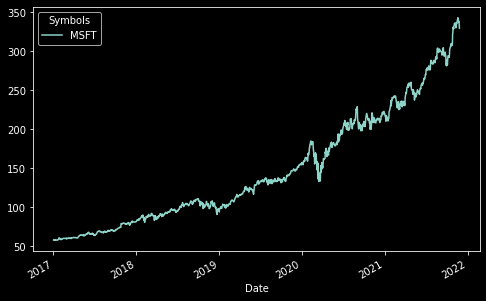

In [3]:
MSFT_precios = pd.DataFrame(get_adj_closes(['MSFT'],'2017-01-01'))
MSFT_precios.plot(figsize=(8,5))

#### Rendimientos de MSFT de inicios del 2017 a la fecha *(26/11/21)*

In [4]:
MSFT_ret = calc_daily_ret(MSFT_precios)
MSFT_ret.head()

Symbols,MSFT
Date,
2017-01-04,-4.474e-03
2017-01-05,0.000e+00
2017-01-06,8.668e-03
2017-01-09,-3.183e-03
2017-01-10,-3.192e-04


In [5]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
calls,puts = options_yf('MSFT')
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,MSFT211203C00225000,2021-10-29 18:39:47,225.0,105.14,103.3,106.80,0.0,0.000,8.0,7,1.450,True,REGULAR,USD
1,MSFT211203C00230000,2021-11-17 16:18:26,230.0,110.75,98.3,101.80,0.0,0.000,NaN,4,1.377,True,REGULAR,USD
2,MSFT211203C00235000,2021-11-24 16:10:58,235.0,100.55,93.3,96.80,0.0,0.000,3.0,5,1.305,True,REGULAR,USD
3,MSFT211203C00240000,2021-11-26 17:18:56,240.0,91.45,88.3,91.80,-8.9,-8.869,5.0,9,1.233,True,REGULAR,USD
4,MSFT211203C00245000,2021-11-26 17:18:53,245.0,86.35,83.3,86.85,-4.2,-4.638,5.0,17,1.176,True,REGULAR,USD


*Para saber que strike podríamos considerar, sería necesario efectuar Análisis Técnico, Fundamental, y estar al día tanto de la economía estadounidense como del mercado bursátil (NYSE) y el sector (software) en el que opera.
Efectuaremos un pequeño análisis técnico, aclarando que este no es un consejo de inversión, ni somos asesores financieros. Este nos servirá para sustentar nuestra decisión en Python sobre el strike elegido y la fecha de ejercicio, de entre las disponibles, para las simulaciones a continuación.* 

Este gráfico fue creado en ThinkorSwim y utilizó los sig. índicadores:

- **Cierre** : Linea horizontal del precio de cierre del día anterior.
- **Apertura**: Línea horizontal del precio de apertura del día curso.
- **Bandas de Bollinger**: Bandas tradicionales con +/- 2 $\sigma$.
- **Medías móviles de 28/100 días**
- **MACD**
- **RSI**
- **STOCH RSI**: Wilders de 80/20 de 14 períodos.
- **Perfil de Volumen customizado**
- **Volume Script:** Indicador creado que ilustra el volumen porcentual y en el gráfico de la vela seleccionada.

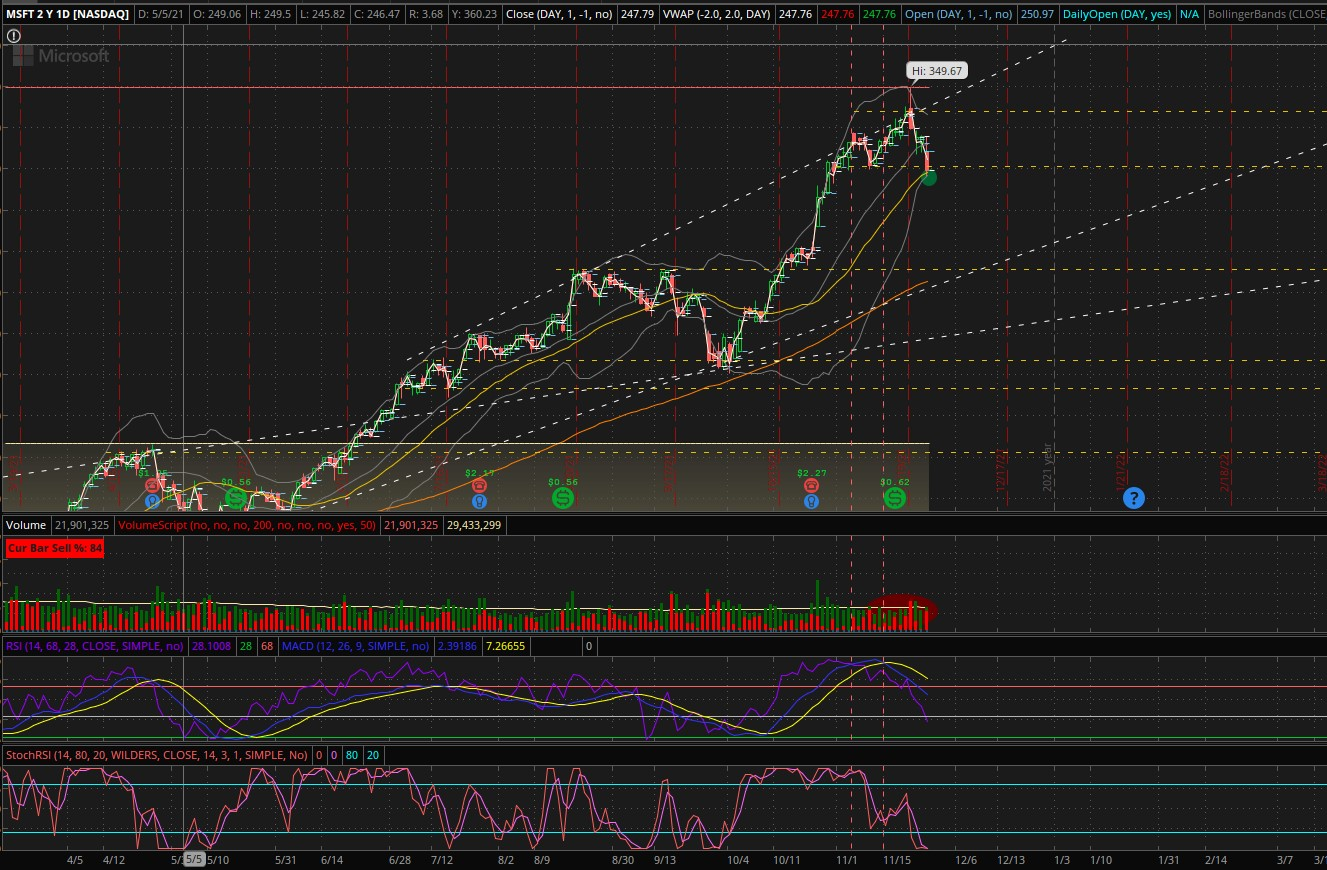

**Interpretación:** *Se puede observar mediante la línea roja que su máximo histórico fue el Lunes 22 de Noviembre y este fue de $349.67. La tendencia alcista que ha impulsado a MSFT durante los últimos meses se vió amenazada desde el 4 de Nov. donde en velas diarias tuvo un cruzo de RSI con MACD graficados en el mismo canal. Para el día siguiente ocurrió el efecto resortera donde amaneció .60 p.p a la alza en apertura de mercado pero los 4 días siguientes fueron rojos, ocurriendo hasta el 2° dia, la retirada de la Estocástica del nivel de sobrecompra, indicando un posterior descenso que se prolongó sólo hasta el siguiente nivel de soporte cuando el mercado aprovechó rápidamente la oportunidad y tuvó un fuerte repunte sólo hasta tocar la Banda de Bollinger superior, momento en el cual el cruce original hacia la baja del MACD acababa de ocurrir y su corrección se dió con más fuerza, lo cual puede apreciarse en la vela diaria ocurrida el pasado Lunes 22 de Noviembre donde el volumen de venta fue de casi el 95 % y aún mayor que su volumen promedio en los últimos 50 días, una clara señal de retirada. De hecho, el cruce hacia la baja de su actual soporte se dió levemente el Viernes aunque aún no es definitivo. La dirección que decida asumir tanto el mercado como MSFT (obedeciendo a su correlación y a su Beta) poco después de la apertura de el Lunes, sería fundamental para tomar posición de calls o de puts. Podríamos considerar elegir de ser Puts aquellos con un strike de 325, su soporte más próximo y de ser Calls de 340, su resistencia más próxima*.

In [6]:
#Información de la opción
MSFT_call = calls.loc[list(calls.strike==340)]
MSFT_call

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
29,MSFT211203C00340000,2021-11-26 17:59:58,340.0,1.38,1.3,1.55,-1.7,-55.195,8429.0,2924,0.301,False,REGULAR,USD


Fue un día duro para este call que se devaluó 55%, sin embargo, quedan 2924 tenedores pero tuvó hasta un volumen de hasta 8429 pues vence el próx. Viernes 3 de Diciembre lo cual significa que MSFT debe subir 3.13% la sig. semana para que el contrato este In The Money, algo ambicioso.

In [7]:
mu = MSFT_ret.mean()
sigma = MSFT_ret.std()
r = 0.0020/360 #Viernes 20/11

### Simulación de precios

In [ ]:
# DATOS PARA LAS SIMULACIONES
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())

# Por el contractSymbol se sabe que expira el 03 de diciembre del 2021. 
# Lo comprobé buscándolo en Yahoo Finance.
expiry = '2021-12-03'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

In [ ]:
# Simulación rendimientos normales
S0 = closes_m.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

In [ ]:
# Definir barrera
B = 320
# Crear función indicadora KNOCK-OUT
I = (sim_closes < B).cumsum(axis=0)  == 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente caluadas
ax = callui.plot();
call.plot(ax=ax);

In [12]:
from datetime import date
#Datos del tiempo actual
today = pd.Timestamp(date.today())
expiry = "2021-12-03" # Esto puede saberse por el nombre de la opción MSFT'211203'C00340000 
# Longitud de hoy hasta el vencimiento
fechas = pd.date_range(start=today, end=expiry, freq='B')
# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(fechas)
nscen = 10000